Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
X = X.drop(columns=['fnlwgt','education'])
num_features = X._get_numeric_data().columns.to_list()

X['income'] = np.where((X['income'] == ' <=50K') , 0, 1)
df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Model training and test

In [3]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.22 s
Wall time: 9.72 s


C:\Users\dinos\anaconda3\envs\work\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11147
           1       0.72      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.80      0.76      0.78     14653
weighted avg       0.84      0.85      0.84     14653



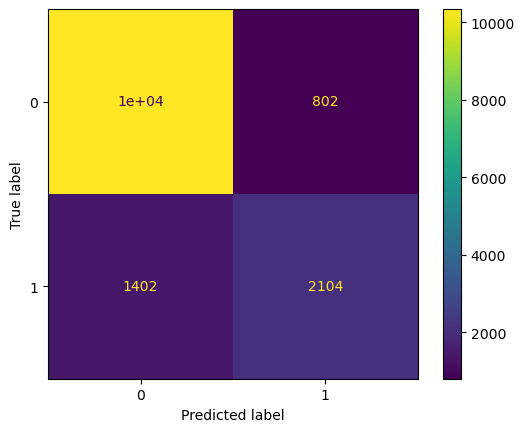

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [8]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp=0.05,
    missing_subgroup_val="Unknown",
    drop_infeasible=False,
    drop_above=False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 136586.11it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|███████████████████████████████████████████████████████████████████████████████| 631/631 [00:01<00:00, 491.20it/s]

Computing correctenesses for all valid if-thens.



100%|██████████████████████████████████████████████████████████████████████████████| 1709/1709 [00:45<00:00, 37.83it/s]

Number of if-thens: 1709


In [8]:
### Uncomment if you wish to load rules object from disk

import dill

with open("rulesAdultFairTest_race.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [9]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_race.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [ ]:
# rules = {}
# features = ['capital-gain','capital-loss']
# for rule in rules_by_if.keys():
#     if all(f not in features for f in rule.features):
#         rules[rule] = rules_by_if[rule]

In [9]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" White"][1][0][1]-e[1][" Black"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, relationship =  Husband:
	Protected Subgroup ' Asian-Pac-Islander', 20.40% covered
		Make relationship =  Wife with correctness 47.22%.
	Protected Subgroup ' Amer-Indian-Eskimo', 22.22% covered
		Make relationship =  Wife with correctness 46.43%.
	Protected Subgroup ' Black', 16.33% covered
		Make relationship =  Wife with correctness 33.00%.
	Protected Subgroup ' Other', 24.79% covered
		Make relationship =  Wife with correctness 36.67%.
	Protected Subgroup ' White', 30.50% covered
		Make relationship =  Wife with correctness 55.29%.
If Workclass =  Private, capital-gain = 0, capital-loss = 0, education-num = 9, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Asian-Pac-Islander', 6.80% covered
		Make education-num = 13 with correctness 12.50%.
	Protected Subgroup ' Amer-Indian-Eskimo', 10.32% covered
		Make education-num = 13 with correctness 46.15%.
	Protected Subgroup ' Black', 8.08% covered
		M

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [10]:
feature_weights = {"sex": 1, "age": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params1 = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [11]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10,
    filter_sequence = [],
    cor_threshold = None,
    secondary_sorting_objectives=[],
    params=params
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, relationship =  Husband:
	Protected Subgroup ' Asian-Pac-Islander', 20.40% covered out of 1519
		Make relationship =  Wife with correctness 47.22%.
		Aggregate cost of the above recourses = -0.47
	Protected Subgroup ' Amer-Indian-Eskimo', 22.22% covered out of 470
		Make relationship =  Wife with correctness 46.43%.
		Aggregate cost of the above recourses = -0.46
	Protected Subgroup ' Black', 16.33% covered out of 4685
		Make relationship =  Wife with correctness 33.00%.
		Aggregate cost of the above recourses = -0.33
	Protected Subgroup ' Other', 24.79% covered out of 406
		Make relationship =  Wife with correctness 36.67%.
		Aggregate cost of the above recourses = -0.37
	Protected Subgroup ' White', 30.50% covered out of 41762
		Make relationship =  Wife with correctness 55.29%.
		Aggregate cost of the above recourses = -0.55
	Bias against  Black. Unfairness measure = 0.22.
If capital-gain = 0, capital-loss 

## Minimum cost above threshold

In [12]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-loss = 0, marital-status =  Married-civ-spouse:
	Subgroup ' Amer-Indian-Eskimo', 30.47% covered out of 470
		Make capital-loss = 1977 with correctness 61.54%.
		Make capital-loss = 1902 with correctness 61.54%.
		Make capital-loss = 1887 with correctness 61.54%.
		Aggregate cost of the above recourses = 1.00
	Subgroup ' Asian-Pac-Islander', 34.23% covered out of 1519
		Make capital-loss = 1977 with correctness 53.54%.
		Make capital-loss = 1902 with correctness 52.76%.
		Make capital-loss = 1887 with correctness 52.76%.
		Aggregate cost of the above recourses = 1.00
	Subgroup ' Black', 21.12% covered out of 4685
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup ' Other', 30.28% covered out of 406
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup ' White', 35.60% covered out of 41762
		Make capital-loss = 1977 with correctness 61.40%.
		Make capital-loss = 1902 with correctness 59.26%.
		Make capi

## Mean cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-loss = 0, marital-status =  Married-civ-spouse:
	Subgroup ' Amer-Indian-Eskimo', 30.47% covered out of 470
		Make capital-loss = 1977 with correctness 61.54%.
		Make capital-loss = 1902 with correctness 61.54%.
		Make capital-loss = 1887 with correctness 61.54%.
		Aggregate cost of the above recourses = 1.00
	Subgroup ' Asian-Pac-Islander', 34.23% covered out of 1519
		Make capital-loss = 1977 with correctness 53.54%.
		Make capital-loss = 1902 with correctness 52.76%.
		Make capital-loss = 1887 with correctness 52.76%.
		Aggregate cost of the above recourses = 1.00
	Subgroup ' Black', 21.12% covered out of 4685
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup ' Other', 30.28% covered out of 406
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup ' White', 35.60% covered out of 41762
		Make capital-loss = 1977 with correctness 61.40%.
		Make capital-loss = 1902 with correctness 59.26%.
		Make capi

## Number above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age = 40, capital-loss = 0, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 2.34% covered out of 470
		Make age = 44 with correctness 66.67%.
		Make age = 50 with correctness 66.67%.
		Make age = 46 with correctness 66.67%.
		Make age = 45 with correctness 66.67%.
		Make age = 42 with correctness 66.67%.
		Make age = 47 with correctness 66.67%.
		Make age = 43 with correctness 66.67%.
		Make age = 55 with correctness 66.67%.
		Make age = 48 with correctness 66.67%.
		Make age = 49 with correctness 66.67%.
		Make age = 51 with correctness 66.67%.
		Make age = 52 with correctness 66.67%.
		Make age = 53 with correctness 66.67%.
		Make age = 58 with correctness 66.67%.
		Make age = 56 with correctness 66.67%.
		Make age = 54 with correctness 66.67%.
		Make age = 57 with correctness 66.67%.
		Make age = 59 with correctness 66.67%.
		Make age = 61 with correctness 66.67%.
		Make age = 62 with correctness 66.67%.
		Aggregate cost of the above recourses = -20.00
	Subgroup ' Asian-Pac-Islande

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [17]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If age = 40, capital-loss = 0, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 2.34% covered out of 470
		Make age = 44 with correctness 66.67%.
		Make age = 50 with correctness 66.67%.
		Make age = 46 with correctness 66.67%.
		Make age = 45 with correctness 66.67%.
		Make age = 42 with correctness 66.67%.
		Make age = 47 with correctness 66.67%.
		Make age = 43 with correctness 66.67%.
		Make age = 55 with correctness 66.67%.
		Make age = 48 with correctness 66.67%.
		Make age = 49 with correctness 66.67%.
		Make age = 51 with correctness 66.67%.
		Make age = 52 with correctness 66.67%.
		Make age = 53 with correctness 66.67%.
		Make age = 58 with correctness 66.67%.
		Make age = 56 with correctness 66.67%.
		Make age = 54 with correctness 66.67%.
		Make age = 57 with correctness 66.67%.
		Make age = 59 with correctness 66.67%.
		Make age = 61 with correctness 66.67%.
		Make age = 62 with correctness 66.67%.
	Subgroup ' Asian-Pac-Islander', 1.08% covered out of 1519
		No recourses for 

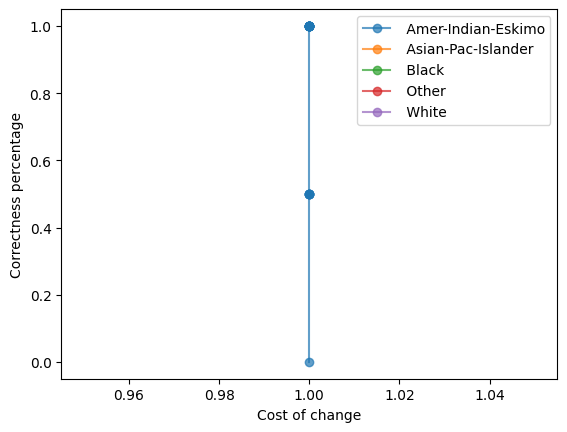

If age = 40, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 2.34% covered out of 470
		Make age = 44 with correctness 66.67%.
		Make age = 46 with correctness 66.67%.
		Make age = 50 with correctness 66.67%.
		Make age = 45 with correctness 66.67%.
		Make age = 42 with correctness 66.67%.
		Make age = 47 with correctness 66.67%.
		Make age = 43 with correctness 66.67%.
		Make age = 48 with correctness 66.67%.
		Make age = 55 with correctness 66.67%.
		Make age = 49 with correctness 66.67%.
		Make age = 51 with correctness 66.67%.
		Make age = 52 with correctness 66.67%.
		Make age = 53 with correctness 66.67%.
		Make age = 56 with correctness 66.67%.
		Make age = 58 with correctness 66.67%.
		Make age = 54 with correctness 66.67%.
		Make age = 59 with correctness 66.67%.
		Make age = 57 with correctness 66.67%.
		Make age = 61 with correctness 66.67%.
		Make age = 62 with correctness 66.67%.
	Subgroup ' Asian-Pac-Islander', 1.08% covered out of 1519
		No recourses for this subgroup!
	Su

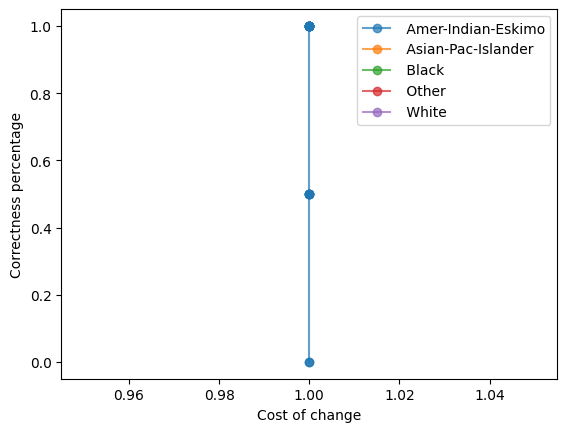

If Workclass =  Private, occupation =  Machine-op-inspct, sex =  Female:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		Make occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make occupation =  Sales, sex =  Male with correctness 50.00%.
		Make occupation =  Craft-repair, sex =  Male with correctness 50.00%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make occupation =  Tech-support, sex =  Male with correctness 50.00%.
		Make Workclass =  Self-emp-not-inc, occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make occupation =  Exec-managerial with correctness 50.00%.
		Make Workclass =  State-gov, occupat

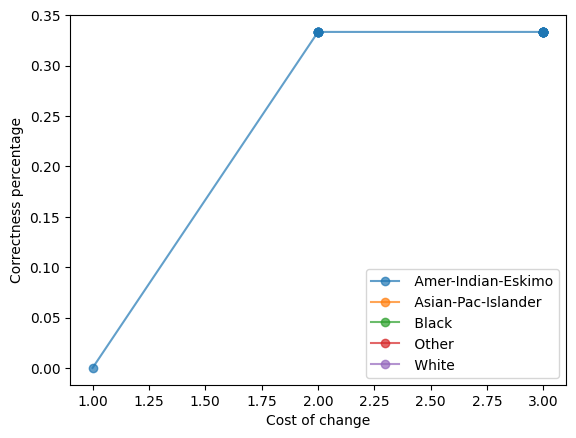

If Workclass =  Private, marital-status =  Never-married, occupation =  Adm-clerical, relationship =  Not-in-family:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		No recourses for this subgroup!
	Subgroup ' Asian-Pac-Islander', 2.16% covered out of 1519
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 100.00%.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Wife with correctness 100.00%.
		Make marital-status =  Married-civ-spouse, relationship =  Wife with correctness 50.00%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 87.50%.
	Subgroup ' Black', 1.40% covered out of 4685
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 55.56%.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relation

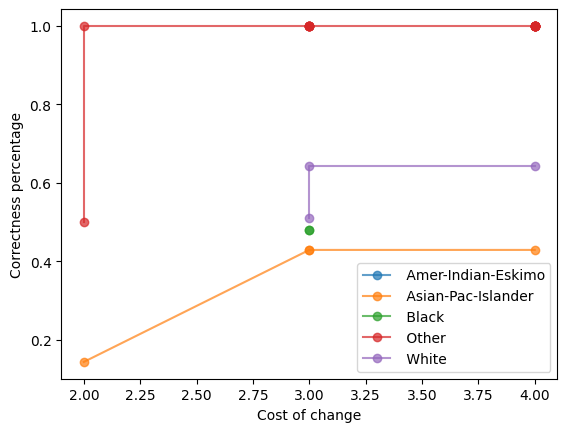

If education-num = 9, hours-per-week = 40, occupation =  Other-service:
	Subgroup ' Amer-Indian-Eskimo', 3.91% covered out of 470
		No recourses for this subgroup!
	Subgroup ' Asian-Pac-Islander', 2.43% covered out of 1519
		Make education-num = 13, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 13, hours-per-week = 50, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 55.56%.
		Make education-num = 13, hours-per-week = 45, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 13, hours-per-week = 50, occupation =  Prof-specialty with correctness 55.56%.
		Make education-num = 13, hours-per-week = 60, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 15, hours-per-week = 50, occupation =  Prof-specialty with correctness 55.56%.
		Make education-nu

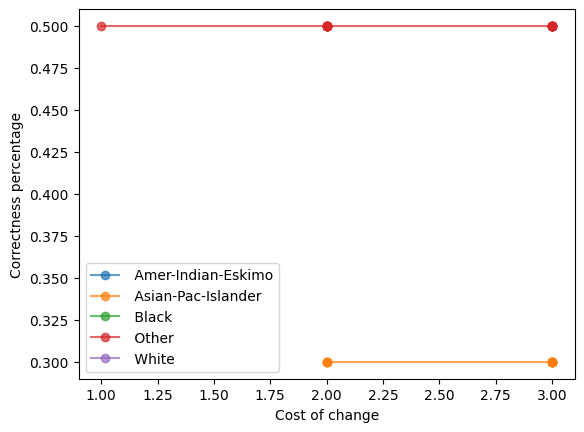

If Workclass =  Private, marital-status =  Never-married, occupation =  Sales, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty with correctness 50.00%.
		Make marital-status =  Married-civ-spouse with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair with correctness 50.00%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, occupation =  Exec-managerial with correctness 50.00%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, occupation =  Prof-specialty with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, occupation =  Tech-support with correctness 50.00%.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, occupation =  Prof-specialty with correctness 50.00%.
		Make W

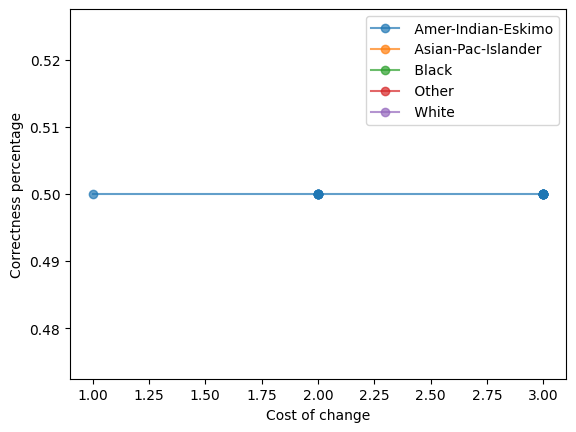

If hours-per-week = 40, occupation =  Machine-op-inspct, sex =  Female:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		Make occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make hours-per-week = 50, occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make hours-per-week = 50, occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make hours-per-week = 45, occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make hours-per-week = 60, occupation =  Exec-managerial, sex =  Male with correctness 50.00%.
		Make occupation =  Sales, sex =  Male with correctness 50.00%.
		Make occupation =  Craft-repair, sex =  Male with correctness 50.00%.
		Make hours-per-week = 60, occupation =  Prof-specialty, sex =  Male with correctness 50.00%.
		Make hours-per-week = 50, occupation =  Sales, sex =  Male with correctness 50.00%.
		Make hours-per-wee

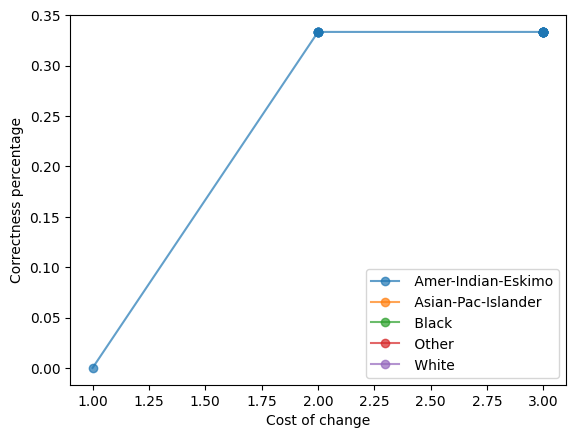

If age = 33, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		No recourses for this subgroup!
	Subgroup ' Asian-Pac-Islander', 2.70% covered out of 1519
		No recourses for this subgroup!
	Subgroup ' Black', 1.71% covered out of 4685
		No recourses for this subgroup!
	Subgroup ' Other', 1.83% covered out of 406
		Make age = 44 with correctness 50.00%.
		Make age = 46 with correctness 50.00%.
		Make age = 50 with correctness 50.00%.
		Make age = 45 with correctness 50.00%.
		Make age = 47 with correctness 50.00%.
		Make age = 43 with correctness 50.00%.
		Make age = 48 with correctness 50.00%.
		Make age = 55 with correctness 50.00%.
		Make age = 49 with correctness 50.00%.
		Make age = 51 with correctness 50.00%.
		Make age = 52 with correctness 50.00%.
		Make age = 53 with correctness 50.00%.
		Make age = 56 with correctness 50.00%.
		Make age = 58 with correctness 50.00%.
		Make age = 54 with correctness 50.00%.
		Make age = 59 with correctness 50.00%.
		Make a

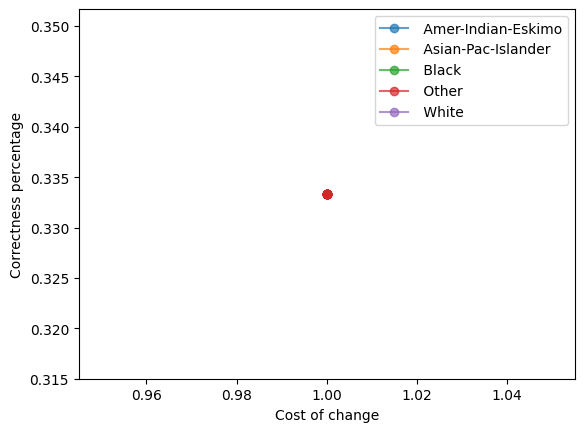

If age = 33, capital-loss = 0, sex =  Male:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		No recourses for this subgroup!
	Subgroup ' Asian-Pac-Islander', 2.70% covered out of 1519
		No recourses for this subgroup!
	Subgroup ' Black', 1.71% covered out of 4685
		No recourses for this subgroup!
	Subgroup ' Other', 1.83% covered out of 406
		Make age = 44 with correctness 50.00%.
		Make age = 50 with correctness 50.00%.
		Make age = 46 with correctness 50.00%.
		Make age = 45 with correctness 50.00%.
		Make age = 47 with correctness 50.00%.
		Make age = 43 with correctness 50.00%.
		Make age = 55 with correctness 50.00%.
		Make age = 48 with correctness 50.00%.
		Make age = 49 with correctness 50.00%.
		Make age = 51 with correctness 50.00%.
		Make age = 52 with correctness 50.00%.
		Make age = 53 with correctness 50.00%.
		Make age = 58 with correctness 50.00%.
		Make age = 56 with correctness 50.00%.
		Make age = 54 with correctness 50.00%.
		Make age = 57 with correctnes

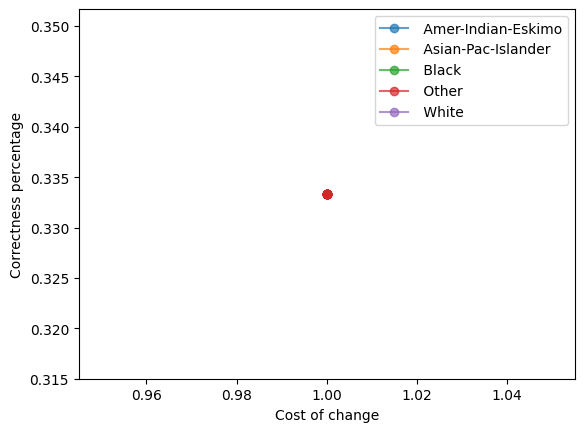

If Workclass =  Private, capital-loss = 0, marital-status =  Never-married, occupation =  Adm-clerical, relationship =  Not-in-family:
	Subgroup ' Amer-Indian-Eskimo', 1.56% covered out of 470
		No recourses for this subgroup!
	Subgroup ' Asian-Pac-Islander', 2.16% covered out of 1519
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 100.00%.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Wife with correctness 100.00%.
		Make marital-status =  Married-civ-spouse, relationship =  Wife with correctness 50.00%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 87.50%.
	Subgroup ' Black', 1.40% covered out of 4685
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Wife with correctness 55.56%.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-ma

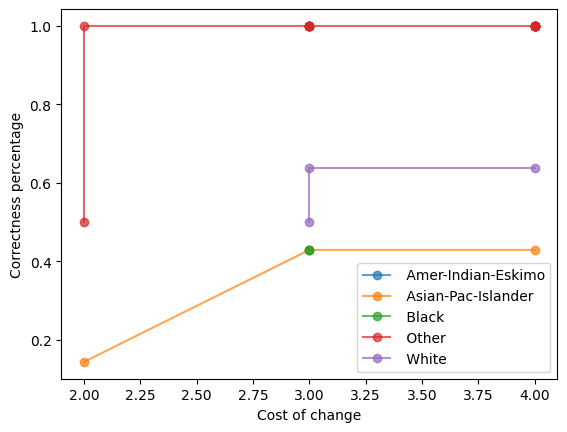

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="race")

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [16]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)